In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

2024-10-14 13:47:17.873399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 13:47:17.876928: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 13:47:17.888048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 13:47:17.908584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 13:47:17.914296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 13:47:17.928724: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Exemplo de função para criar sequências de 5 imagens anteriores e 3 imagens futuras
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
base_path = f"{os.environ['HOME']}/lectures"
data_path = f"{base_path}/data/processed/netcdf/temperature_1000hPa"
results_path = f"{base_path}/results/temperature_1000hPa"

In [4]:
ds_train = xr.open_dataset(f"{data_path}/temperature_1000hPa_2019_train.nc")['t'].values
ds_train = np.pad(ds_train, pad_width=((0, 0), (7, 8), (2, 3)), mode='constant', constant_values=0)

ds_train.shape

(8760, 64, 64)

In [14]:
# Criar sequências de entrada (5 imagens anteriores) e saída (3 imagens futuras)
n_steps_in = 5  # Número de imagens passadas
n_steps_out = 3  # Número de imagens futuras
X_data, y_data = create_sequences(ds_train, n_steps_in, n_steps_out)

# Reshape para adicionar o canal de input/output
X_data = X_data.reshape((X_data.shape[0], X_data.shape[2], X_data.shape[3], n_steps_in))  # (samples, 49, 59, 5)
y_data = y_data.reshape((y_data.shape[0], y_data.shape[2], y_data.shape[3], n_steps_out))  # (samples, 49, 59, 3)
X_data.shape, y_data.shape

((8753, 64, 64, 5), (8753, 64, 64, 3))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7002, 64, 64, 5), (1751, 64, 64, 5), (7002, 64, 64, 3), (1751, 64, 64, 3))

In [16]:
def unet_model(input_shape=(64, 64, 5)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder (Downsampling)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Upsampling)
    u5 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Saída com 3 canais (previsão de 3 imagens futuras)
    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='linear')(c7)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [17]:
# Criar o modelo U-Net
input_shape = (64, 64, 5)  # Entradas: 5 imagens anteriores (stack de 5 canais)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='mse')

# Resumo do modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 5) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      2,944 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 256) │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 16, 16,    │    524,544 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │  1,179,904 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │    131,200 │ conv2d_24[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,698,627 (29.37 MB)

 Trainable params: 7,698,627 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

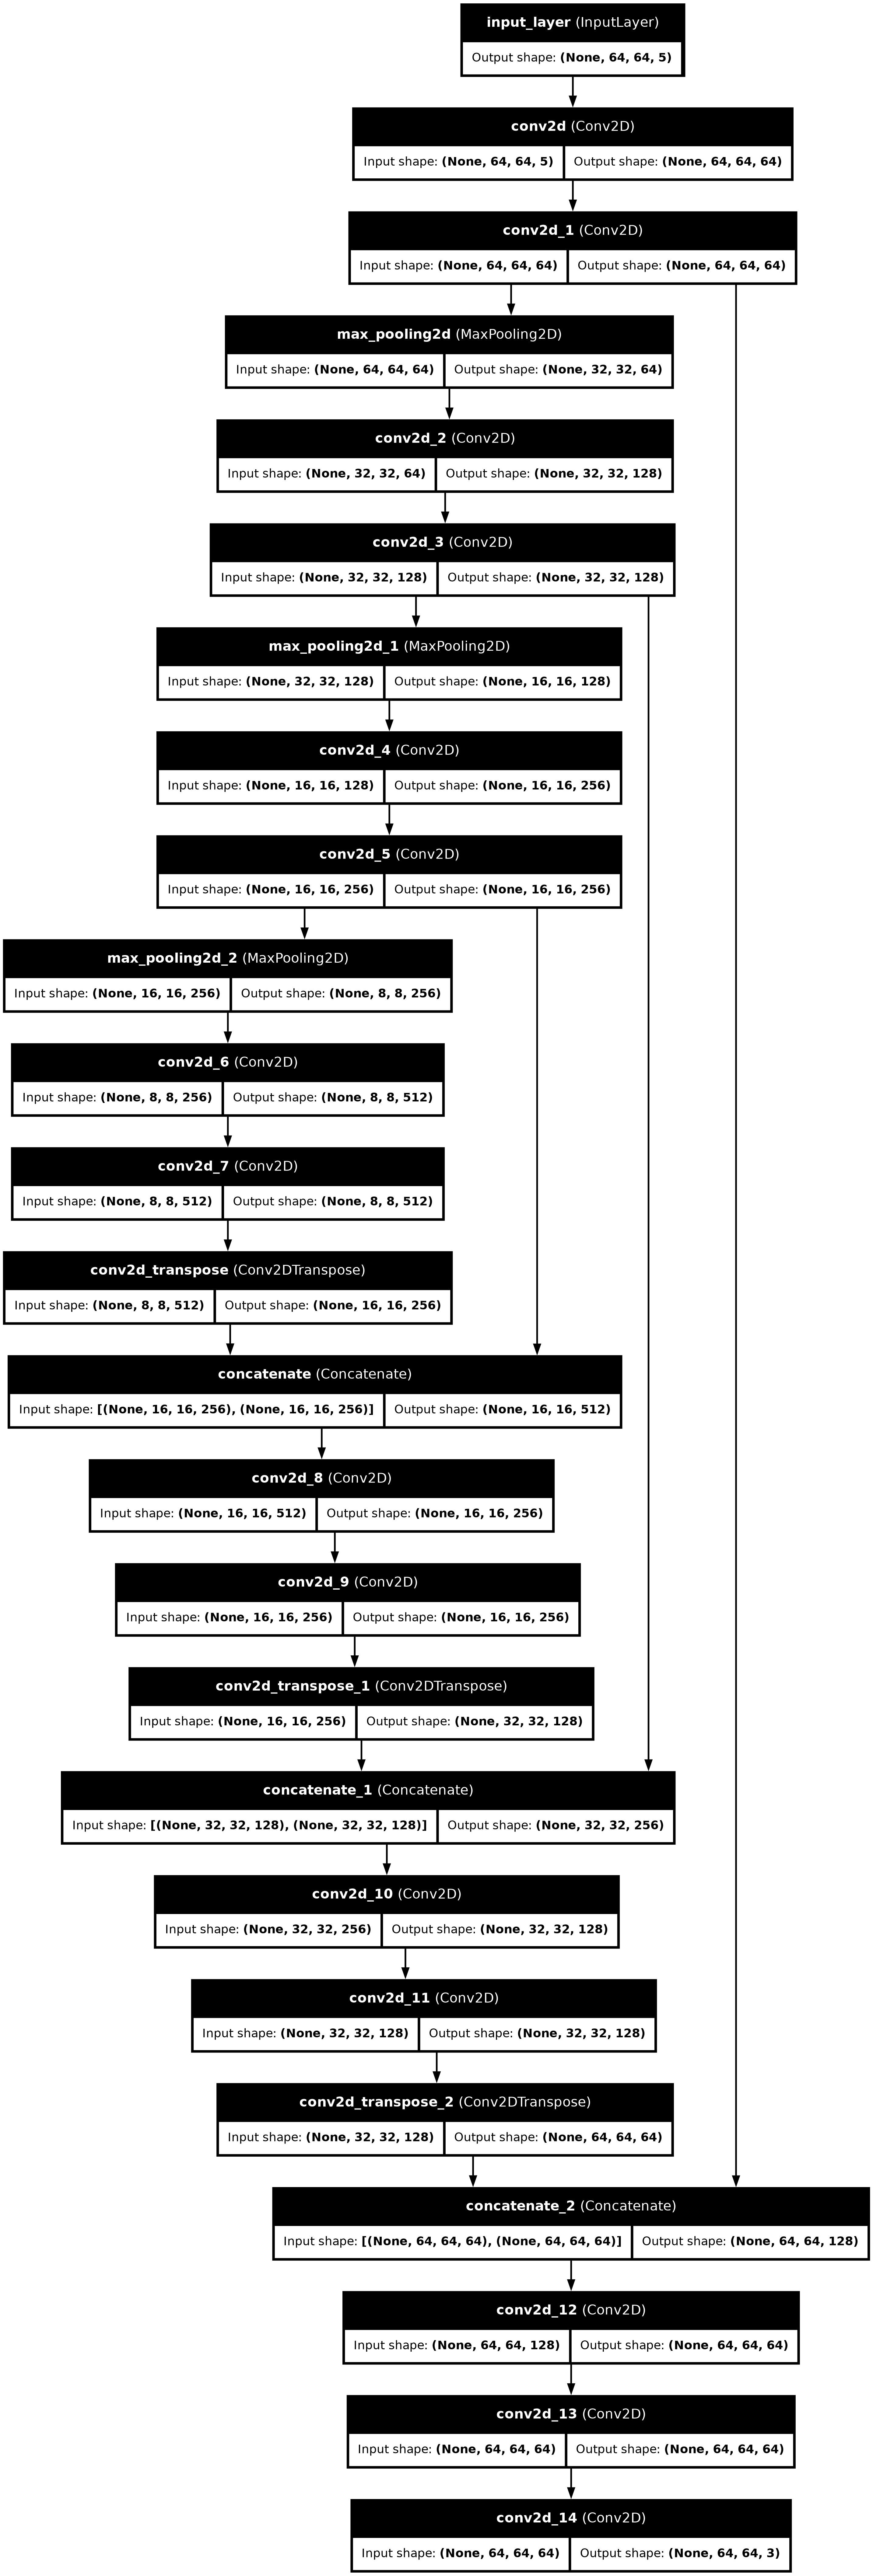

In [10]:
#plot unet model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file=f"{results_path}/unet_model.png")

In [18]:
# Definir o Cosine Decay with Restarts
initial_learning_rate = 0.001  # Define a taxa de aprendizado inicial
first_decay_steps = 20       # Número de passos para o primeiro ciclo
t_mul = 2.0                    # Fator de multiplicação para aumentar o número de passos a cada reinício
m_mul = 1.0                    # Multiplicador para o learning rate após cada reinício (1.0 mantém o mesmo valor)
alpha = 0.0                    # Limite inferior da taxa de aprendizado

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=t_mul,
    m_mul=m_mul,
    alpha=alpha
)

# Aplicar o scheduler no otimizador Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compilar o modelo com o otimizador que usa CosineDecayRestarts
model.compile(optimizer=optimizer, loss='mse')

In [19]:
# Treinamento do modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)


2024-10-14 13:52:36.860419: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 573603840 exceeds 10% of free system memory.


Epoch 1/10


2024-10-14 13:52:38.082574: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 344162304 exceeds 10% of free system memory.
/home/adriano/lectures/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_25']. Received: the structure of inputs=*
  warnings.warn(


 3/55 ━━━━━━━━━━━━━━━━━━━━ 8:25 10s/step - loss: 4065.1792

KeyboardInterrupt: 